# XGB Regression Model

**Build the opening box office prediction model using the dataframe generated from Notebook 14.**

In [1]:
import os
import collections
from time import time
from multiprocessing import Pool, cpu_count
import tqdm  # show multi-processing progress bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb

from model_util import *
from data_util import *

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

## 1. Load Data

In [2]:
file = "./data/movie_2014-2019.csv"
df = pd.read_csv(file)
with open("./data/movie_list/_excluded_movies.txt", "r") as f:
    excluded_movies = f.read().split('\n')
df = df[~df['Title'].isin(excluded_movies)]
df = df[df.budget > 1]
df = df.reset_index(drop=True)
print("Movie number: {}".format(df.shape[0]))

Movie number: 696


## 2. Build features

In [3]:
with_Trailer = False  # use trailer info or not
director_power = True  # use categorical director features, or director power features.
actor_power = True  # use categorical actor features, or actor power features.

columns_to_drop = ['Rank', 'Title', 'tt_id', 'rl_id', 'release_date', 
                   'company', 'mpaa', 'genres', 'director', 'actors', 
                   'bo_opening', 'bo_gross', 'imdb_score', 'budget', 
                   'trailer_viewCount',  ]
if not with_Trailer:
    columns_to_drop += ['trailer_like_dislike_ratio', 'trailer_commentCount', 'trailer_mean_sentiment', 
                        'trailer_pos_sentiment_ratio', 'trailer_neg_sentiment_ratio']  

feature_process_budget(df)
feature_process_title(df)
feature_process_date(df)
feature_process_mpaa(df)
feature_process_genre(df, top=15)
feature_process_company(df, top=8)
if director_power:
    feature_process_director_power(df)
else:
    feature_process_director(df)
if actor_power:
    feature_process_actor_power(df)
else:
    feature_process_actor(df)


/Users/zhao/Dropbox/Jupyter_notebooks/Trailer_Miner/data_util.py:234: RuntimeWarning: Mean of empty slice
  df.loc[i, 'actors_bo_power'] = np.nanmean(act_bo)
/Users/zhao/Dropbox/Jupyter_notebooks/Trailer_Miner/data_util.py:235: RuntimeWarning: Mean of empty slice
  df.loc[i, 'actors_imdb_power'] = np.nanmean(act_imdb)


## 3. Build model

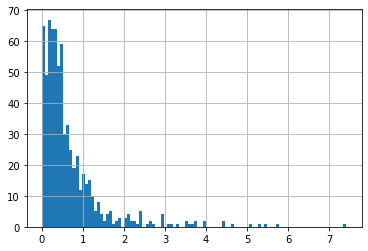

In [4]:
X = df.drop(columns_to_drop, axis=1)
y = df['bo_opening'] / df['budget']
y.hist(bins=100)

In [5]:
train_idx = X[X.Year < 2019].index
test_idx  = X[X.Year == 2019].index
X_train = X.iloc[train_idx, :]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx]
print("X_train shape:", X_train.shape)
print("X_test samples:", X_test.shape)

X_train shape: (593, 41)
X_test samples: (103, 41)


In [6]:
params = { 
    'n_estimators': 700,  #################
    'max_depth':  5,  #################
    'learning_rate': 0.02, 
#     'min_child_weight': np.arange(1, 4, 1),
#     'gamma': np.arange(0, 0.03, 0.01),
#     'reg_alpha': np.arange(0, 0.01, 0.003),
    'objective': 'reg:squarederror', #['reg:squaredlogerror']#, # squared loss.
    'verbosity': 0,
    'early_stopping_rounds': None,
    'n_jobs': -1,
    'random_state': 123
}

model = RegressorModel(model_wrapper=XGBWrapper_regr())
model.fit(X_train, y_train, n_splits=15, params=params, eval_metric='rmse', verbose=2, plot=False)
y_test_pred = model.predict(X_test)

r2_train = r2_score(model.oof, y_train)
r2_test  = r2_score(y_test_pred, y_test)
print("Train r2 = {:.3f}".format(r2_train))
print("Test  r2 = {:.3f}".format(r2_test))


Fold 0 started.
rmse score on validation_0: 0.084.
rmse score on validation_1: 0.660.

Fold 1 started.
rmse score on validation_0: 0.076.
rmse score on validation_1: 0.761.

Fold 2 started.
rmse score on validation_0: 0.077.
rmse score on validation_1: 0.486.

Fold 3 started.
rmse score on validation_0: 0.076.
rmse score on validation_1: 0.823.

Fold 4 started.
rmse score on validation_0: 0.080.
rmse score on validation_1: 0.630.

Fold 5 started.
rmse score on validation_0: 0.082.
rmse score on validation_1: 0.273.

Fold 6 started.
rmse score on validation_0: 0.079.
rmse score on validation_1: 0.892.

Fold 7 started.
rmse score on validation_0: 0.093.
rmse score on validation_1: 0.350.

Fold 8 started.
rmse score on validation_0: 0.084.
rmse score on validation_1: 0.486.

Fold 9 started.
rmse score on validation_0: 0.092.
rmse score on validation_1: 0.848.

Fold 10 started.
rmse score on validation_0: 0.081.
rmse score on validation_1: 0.674.

Fold 11 started.
rmse score on validation

In [7]:
str1 = "crew_power" if director_power else "crew_categ"
str2 = "__w_trailer" if with_Trailer else "__wo_trailer"
model_name = str1 + str2 + ".model"
model.save_model("./models/{}".format(model_name))

In [8]:
train_truth = np.array(y_train * df.loc[train_idx, 'budget'])
train_pred = np.array(model.oof * df.loc[train_idx, 'budget'])
test_truth = np.array(y_test * df.loc[test_idx, 'budget'])
test_pred = np.array(y_test_pred * df.loc[test_idx, 'budget'])

r2_train = r2_score(train_pred, train_truth)
r2_test  = r2_score(test_pred, test_truth)

error_tolerance = 0.3
in_range_train = calc_in_range_percent(train_pred, train_truth, error_tolerance)
in_range_test  = calc_in_range_percent(test_pred, test_truth, error_tolerance)
print("Train: r2 = {:.3f}. {:.1f}% within +/- {:.1f}% error.".format(r2_train, 100 * in_range_train, 100 * error_tolerance))
print("Test:  r2 = {:.3f}. {:.1f}% within +/- {:.1f}% error.".format(r2_test, 100 * in_range_test, 100 * error_tolerance))

Train: r2 = 0.451. 36.6% within +/- 30.0% error.
Test:  r2 = 0.367. 33.0% within +/- 30.0% error.


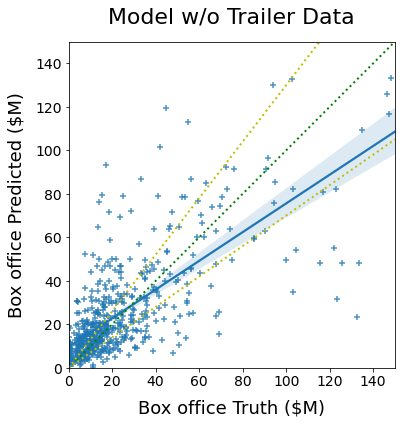

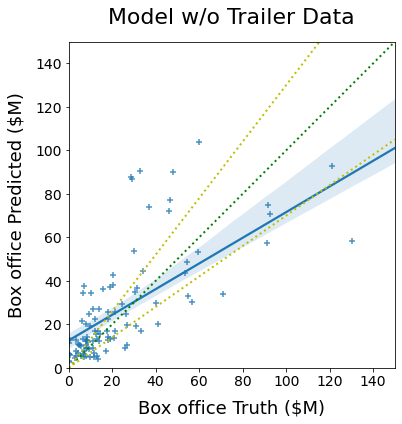

In [11]:
plot_scatter_preds(train_pred, train_truth, 0.3)
plot_scatter_preds(test_pred, test_truth, 0.3)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


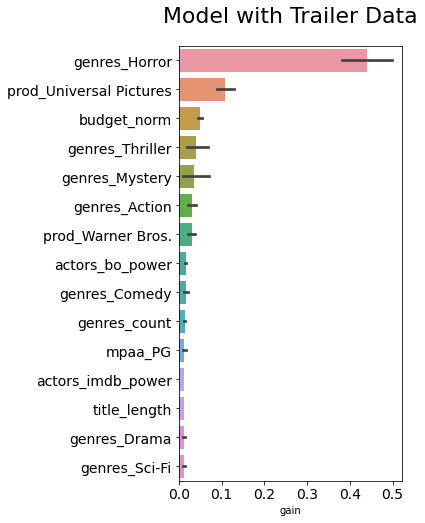

In [10]:
model.plot_feature_importance(top_n=15)

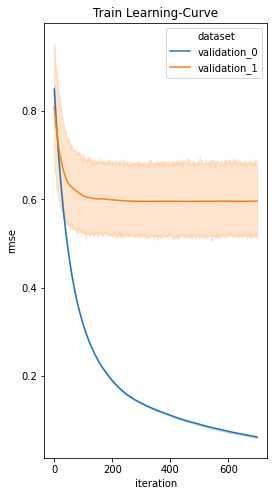

In [21]:
model.plot_learning_curve()